In [24]:
import pandas as pd
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})

In [2]:
sponsUnitResearchers = pd.read_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")

In [3]:
#data for 2010 or earlier
startData = sponsUnitResearchers[sponsUnitResearchers.Year <= 2010]

In [4]:
#totalSize = startData.groupby('SponsoringUnitName').count()['SearchName'].reset_index()
sizePerYear = startData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [5]:
invited = startData[startData.SessionType == 'invited']
attendees = startData[startData.SessionType == 'attendee']

In [6]:
invitedPerYear = invited.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendees.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [7]:
#create list of sponsoring units + remove None
sponsoringUnits = startData.SponsoringUnitName.unique().tolist()
sponsoringUnits.remove(None)

In [8]:
#find female ratio for each sponsoring unit
index = 0
femaleRatioInv_dict = {}
femaleRatioAtt_dict = {}
for i in sponsoringUnits:
    sponsoringUnitInv = invited[invited.SponsoringUnitName == i]
    sponsoringUnitAtt = attendees[attendees.SponsoringUnitName == i]
    invited_crossTab = pd.crosstab(index = sponsoringUnitInv.Year, columns = sponsoringUnitInv.Gender,
                                      normalize = "index")['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_inv'})
    invited_crossTab['SponsoringUnitName'] = i
    
    if len(sponsoringUnitAtt) > 0: #if any attendees in sponsoring unit
        attendees_crossTab = pd.crosstab(index = sponsoringUnitAtt.Year, columns = sponsoringUnitAtt.Gender,
                                        normalize = 'index')['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_att'})
        attendees_crossTab['SponsoringUnitName'] = i
    else:
        continue
    invitedDict = invited_crossTab.to_dict('list')
    attendeesDict = attendees_crossTab.to_dict('list')
    femaleRatioInv_dict[index] = invitedDict
    femaleRatioAtt_dict[index] = attendeesDict
    index += 1

In [9]:
femaleRatio_inv = pd.DataFrame.from_dict(femaleRatioInv_dict, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleRatioAtt_dict, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [10]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.fillna(0) #substitute NaN with 0, because this is when there is 0 attendees


#if there are no attendees, we can not just say that the gender ratio is 0
#maybe we should just skip this

In [11]:
def standardizeColumn(df, columnName):
    standardizedColumn = (df[columnName] - df[columnName].mean())/(df[columnName].std())
    
    return standardizedColumn

In [13]:
def KNN(df, features, K):
    neighborDict = {}
    index = 0
    df_stand = df.copy()
    
    for c in features:
        df_stand[c] = standardizeColumn(df_stand, c) #standardize data
    
    years = df.Year.unique()
    for y in years:
        year_df = df_stand[df_stand.Year == y]
        
        #do KNN
        neighbors = NearestNeighbors(n_neighbors = K, metric = 'manhattan').fit(year_df[features])
        kNeighbor_dist = neighbors.kneighbors(year_df[features])[0][:,1] #use the second index(first is itself)
        kNeighbor_ind = neighbors.kneighbors(year_df[features])[1][:,1] #use the second index(first is itself)
        
        unitOrder = year_df.SponsoringUnitName.values.tolist() #list of sponsoring unit(and order of it)
        for i in range(0,len(unitOrder)):
            neighborDict[index] = {'SponsoringUnit': unitOrder[i], 'Year': y, 'NearestNeighbor': unitOrder[kNeighbor_ind[i]], 'Distance': kNeighbor_dist[i]}
            index += 1
    return neighborDict

In [ ]:
def plotNeighbors(neighbors, df):
    for i in neighbors.keys():
        neighborList = neighborMatch[i].values()
        femaleRatio_neighbors = df[df.SponsoringUnit.isin(neighborList)]
        years = femaleRatio_neighbors.Year.unique()
        sns.lineplot(data = femaleRatio_neighbors, x = 'Year', y = 'Female', hue = 'SponsoringUnit')
        plt.axvline(x = 2010, color = 'black', linewidth = 1)
        plt.xticks(np.arange(min(years), max(years)+1, 2.0))
        plt.show()

In [17]:
features = ['UnitSize', 'n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att']
KNN_dict = KNN(sponsorUnit_df, features, 2)

In [19]:
neighbor_df = pd.DataFrame.from_dict(KNN_dict , orient='index')

In [20]:
neighborMatch = {}
index = 0
neighborCount = neighbor_df.groupby(['SponsoringUnit', 'NearestNeighbor']).count().reset_index()
for i in sponsoringUnits:
    match = neighborCount[neighborCount.SponsoringUnit == i].max()
    #.max().NearestNeighbor
    neighborMatch[index] = {'SponsoringUnit': match.SponsoringUnit, 'NearestNeighbor': match.NearestNeighbor}
    index += 1

In [21]:

neighborMatch_df = pd.DataFrame.from_dict(neighborMatch , orient='index')
#27 x 36,5

In [22]:
female_df = pd.DataFrame()
for i in sponsoringUnits:
    unitData = sponsUnitResearchers[sponsUnitResearchers.SponsoringUnitName == i]
    table = pd.crosstab(index = unitData.Year, columns = unitData.Gender, normalize = 'index').reset_index()[['Year', 'Female']]
    table['SponsoringUnit'] = i
    female_df = pd.concat([female_df, table])
female_df = female_df.reset_index(drop = True)

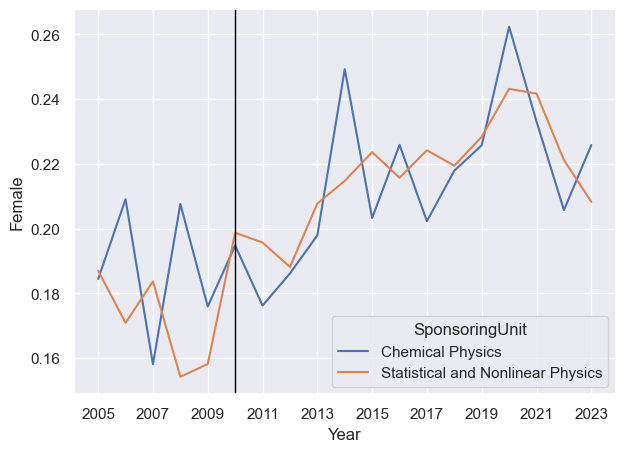

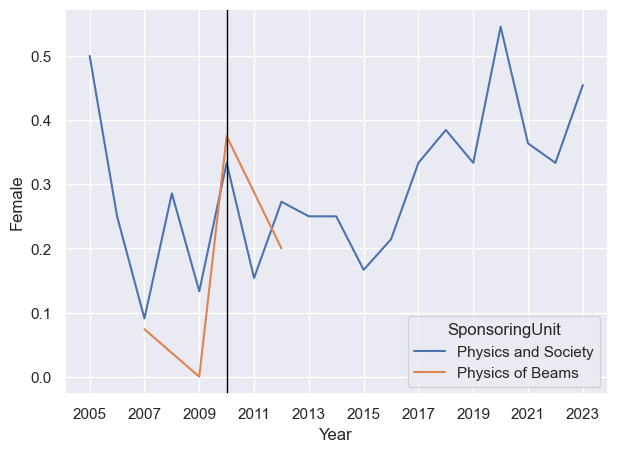

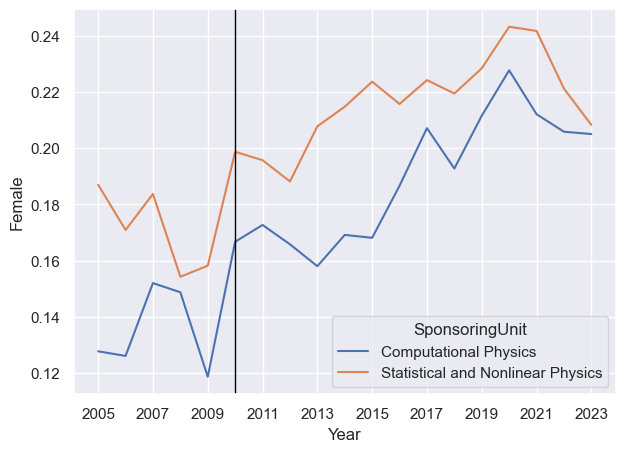

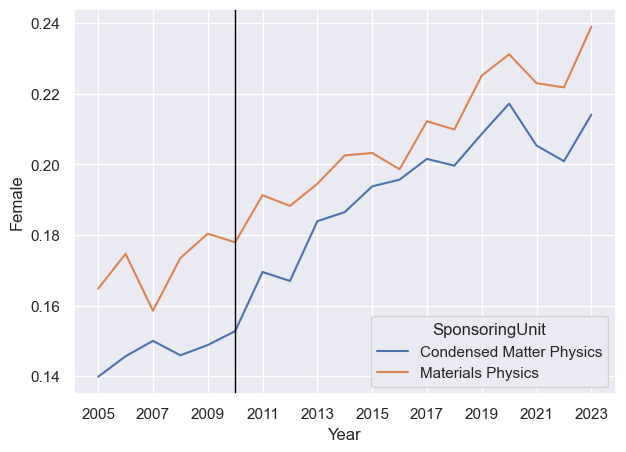

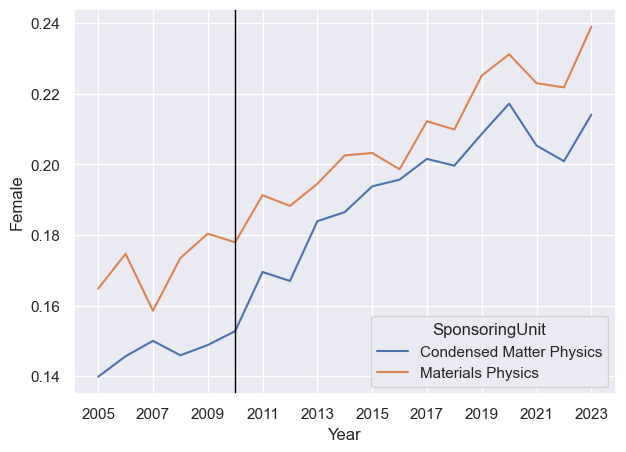

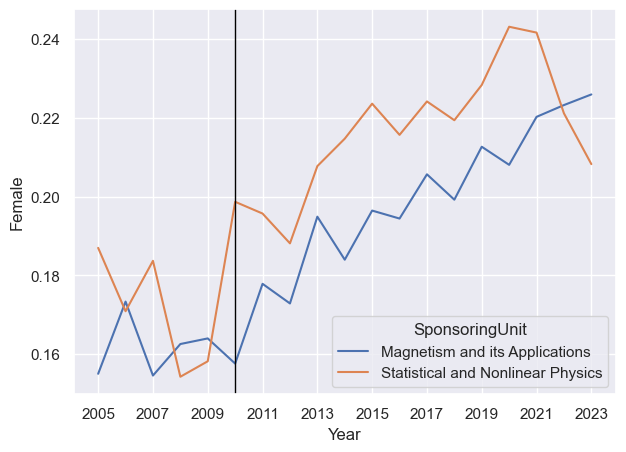

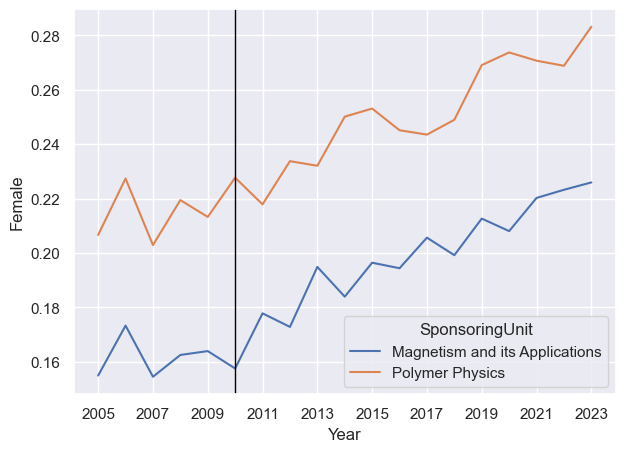

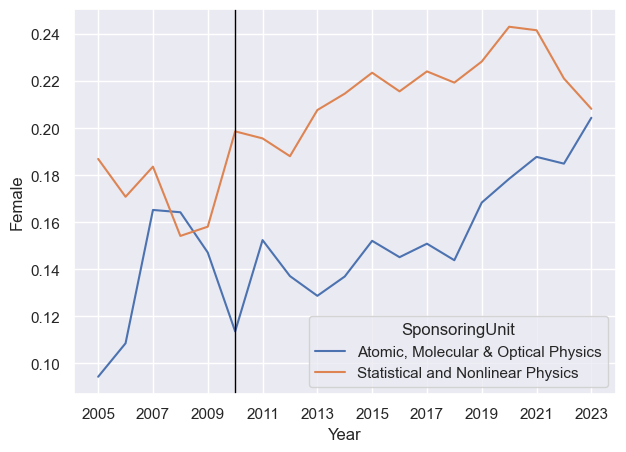

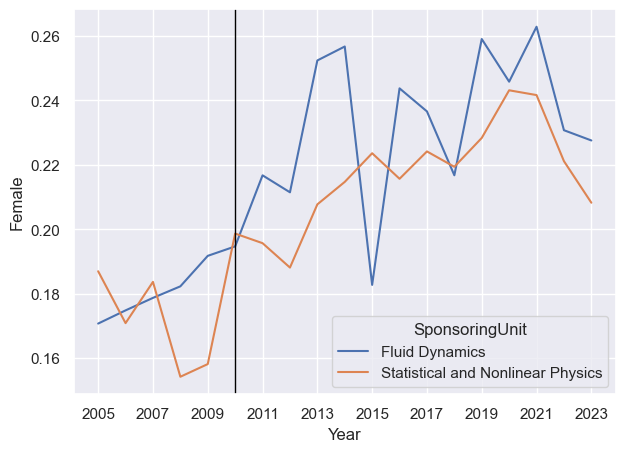

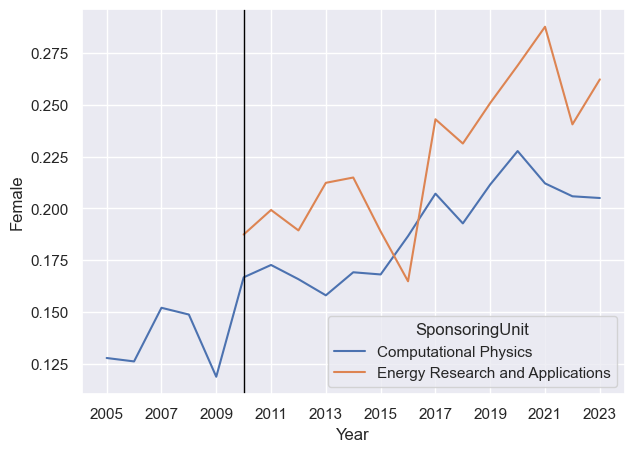

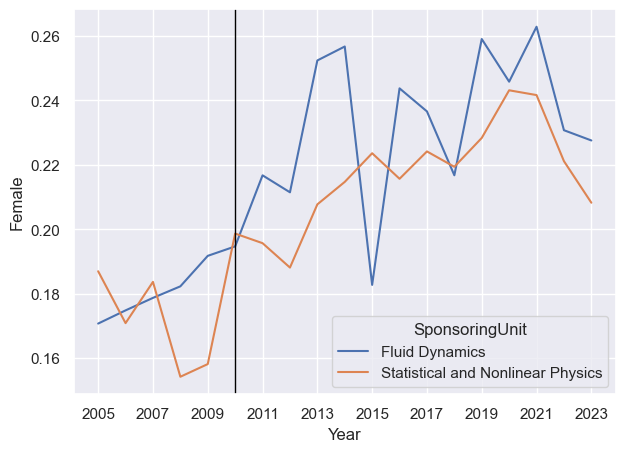

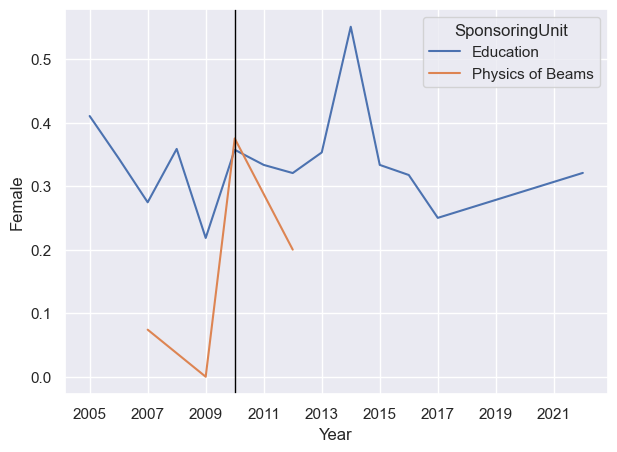

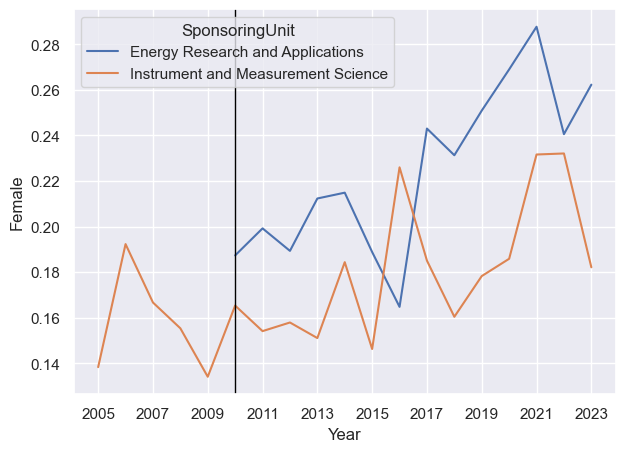

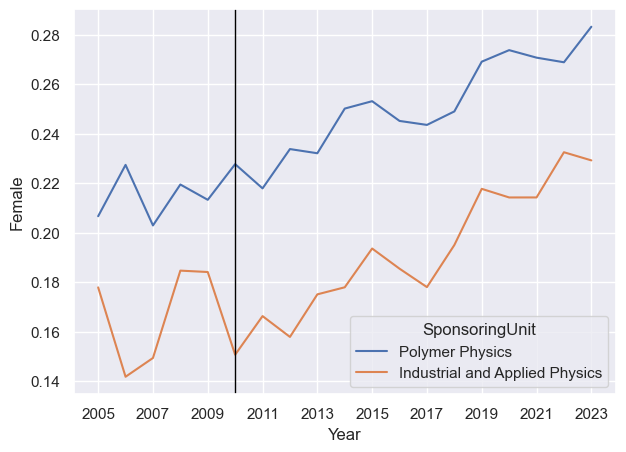

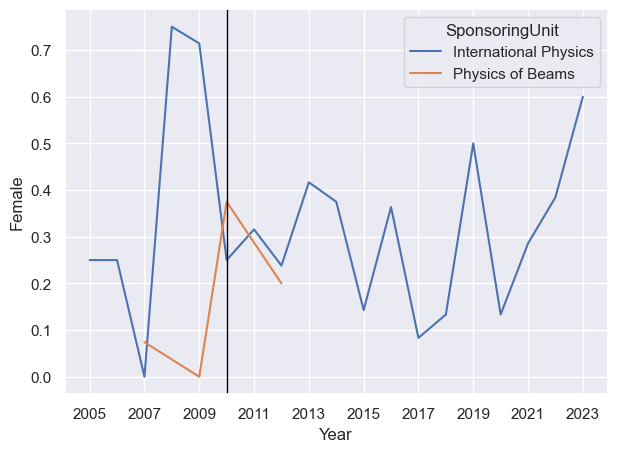

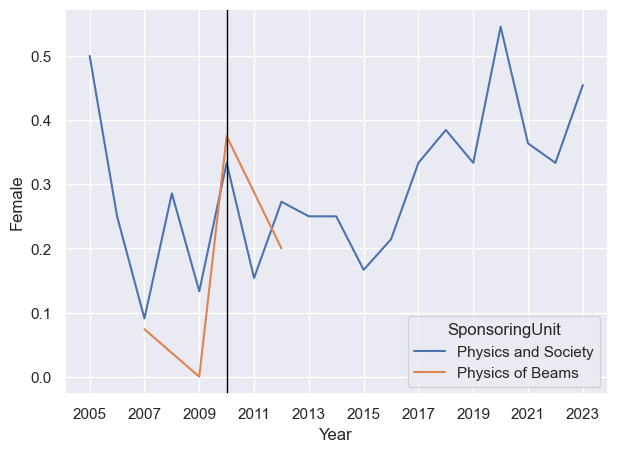

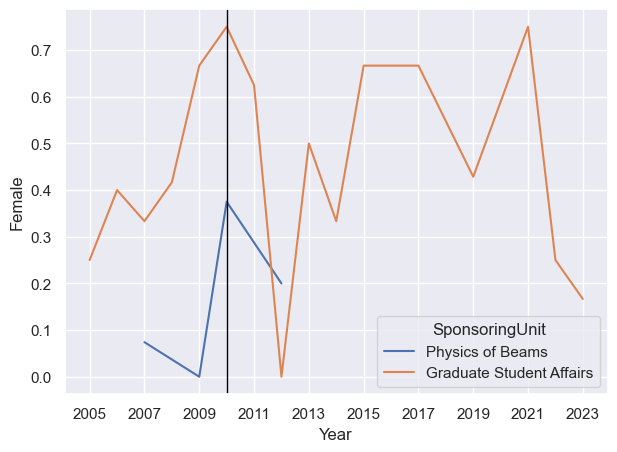

In [40]:
plotNeighbors(neighborMatch, female_df)

In [415]:
#do some kind of filtering, so we do not compare with units with only 3 years ahead